# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [78]:
p1, p2 = 8 / 10, 2 / 10
print(f"Энтропия распределения классов равна: {np.round(-(p1 * np.log(p1) + p2 * np.log(p2)), 2)}")

Энтропия распределения классов равна: 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [79]:
def count_Gini_index(p1: float, p2: float) -> float:
  return (p1 * (1 - p1) + p2 * (1 - p2))

print(f"Критерий информативности равен: {np.round(count_Gini_index(p1, p2) - p1 * count_Gini_index(1, 0) - p2 * count_Gini_index(0, 1), 2)}")

Критерий информативности равен: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [80]:
y_values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
print(f"Предсказания модели для этих объектов равны: {np.round(sum(y_values) / len(y_values), 2)}")

Предсказания модели для этих объектов равны: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [81]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [82]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    thresholds = np.unique(feature_vector)

    if feature_type == "real":
        thresholds = (thresholds[:-1] + thresholds[1:]) / 2

    def find_Gini(cur_threshold):
      if feature_type == 'real':
        less_threshold, more_threshold = feature_vector <= cur_threshold, feature_vector > cur_threshold

      elif feature_type == 'categorical':
        less_threshold, more_threshold = feature_vector == cur_threshold, feature_vector != cur_threshold

      left_side_values, right_side_values = target_vector[less_threshold], target_vector[more_threshold]

      if task == 'classification':
        _, counts = np.unique(target_vector, return_counts=True)
        _, counts_left_side = np.unique(left_side_values, return_counts=True)
        _, counts_right_side = np.unique(right_side_values, return_counts=True)
        H = counts / len(target_vector); Hl = counts_left_side / len(left_side_values); Hr = counts_right_side / len(right_side_values)
        H *= (1 - H); Hl *= (1 - Hl); Hr *= (1 - Hr)
        gini_value = (H).sum() - (len(left_side_values) / len(feature_vector) * (Hl).sum()) - ((len(right_side_values) / len(feature_vector)) * (Hr).sum())

      elif task == 'regression':
        gini_value = target_vector.var() - (len(left_side_values) / len(feature_vector) * left_side_values.var()) - (len(right_side_values) / len(feature_vector) * right_side_values.var())

      return gini_value

    ginis = np.vectorize(find_Gini)(thresholds)
    threshold_best, gini_best = thresholds[np.argmax(ginis)], ginis[np.argmax(ginis)]

    return thresholds, ginis, threshold_best, gini_best


Эту функцию можно протестировать на датасете `California`.

In [83]:
from sklearn.datasets import fetch_california_housing

In [84]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [85]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

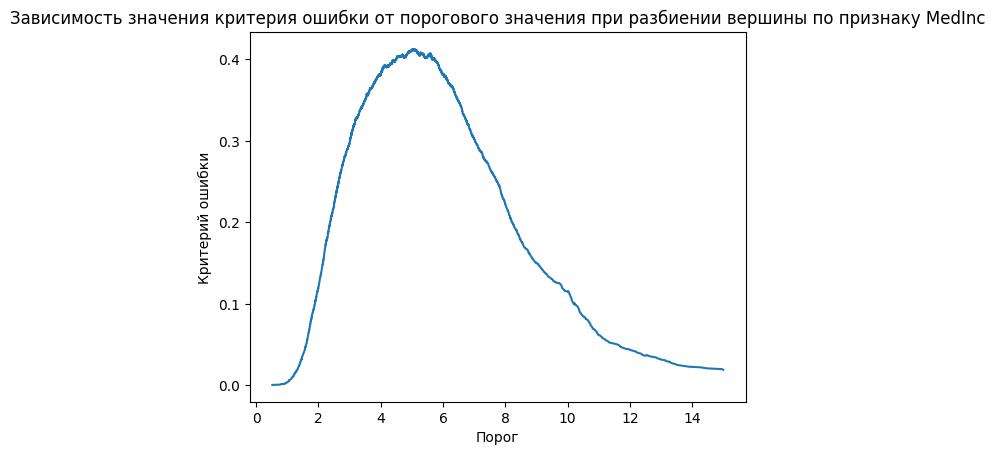

In [86]:
thresholds, variances, threshold_best, variance_best = find_best_split(X["MedInc"], y, task="regression")

plt.plot(thresholds, variances)
plt.xlabel("Порог")
plt.ylabel("Критерий ошибки")
plt.title("Зависимость значения критерия ошибки от порогового значения при разбиении вершины по признаку MedInc")
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [87]:
best_threshold, best_var, best_feature = -1e9, -1e9, None
for feature in range(X.shape[1]):
    thresholds, variances, threshold_best, variance_best = find_best_split(X.iloc[:, feature].to_numpy(), y, task="regression")
    if(best_var < variance_best):
        best_var = variance_best
        best_threshold = threshold_best
        best_feature = X.columns[feature]
print(f"Оптимальный порог первой вершины решающего дерева равен: {best_threshold}")
print(f"Наилучшее значение критерия ошибки: {best_var}")
print(f"Наилучший признак для разбиения: {best_feature}")

Оптимальный порог первой вершины решающего дерева равен: 5.03515
Наилучшее значение критерия ошибки: 0.4127513862016769
Наилучший признак для разбиения: MedInc


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [88]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """

        if node["type"] == "terminal":
            return node["class"]

        feature_split = node["feature_split"]

        if self._feature_types[feature_split] == "real":
            if x[feature_split] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            return self._predict_node(x, node["right_child"])

        elif self._feature_types[feature_split] == "categorical":
            if x[feature_split] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)


**Добавлен метод fill_missing_values для заполнения пропусков.**

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [89]:
!wget https://github.com/PiginIvan/Archives/raw/main/students.csv

--2024-05-23 08:25:08--  https://github.com/PiginIvan/Archives/raw/main/students.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PiginIvan/Archives/main/students.csv [following]
--2024-05-23 08:25:08--  https://raw.githubusercontent.com/PiginIvan/Archives/main/students.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7794 (7.6K) [text/plain]
Saving to: ‘students.csv.1’

students.csv.1      100%[===================>]   7.61K  --.-KB/s    in 0s      

2024-05-23 08:25:08 (60.6 MB/s) - ‘students.csv.1’ saved [7794/7794]



In [90]:
df = pd.read_csv('students.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head(5)

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


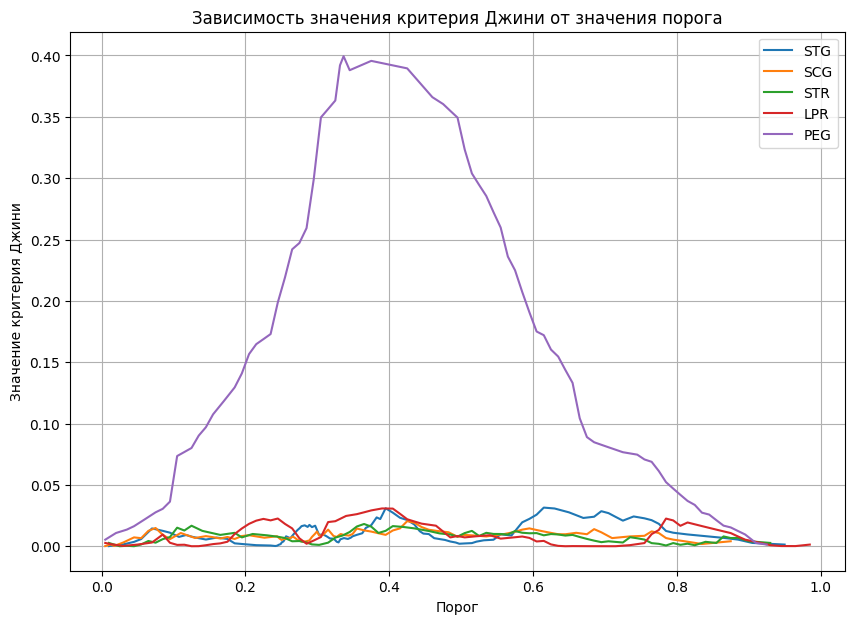

In [91]:
y = df['UNS']
X = df.drop(['UNS'], axis=1)

plt.figure(figsize=(10, 7))

for feature in range(X.shape[1]):
    thresholds, variances, threshold_best, variance_best = find_best_split(X.iloc[:, feature].to_numpy(), y, task="classification", feature_type="real")
    plt.plot(thresholds, variances, label=X.columns[feature])

plt.title("Зависимость значения критерия Джини от значения порога")
plt.xlabel("Порог")
plt.ylabel("Значение критерия Джини")
plt.grid()
plt.legend()
plt.show()

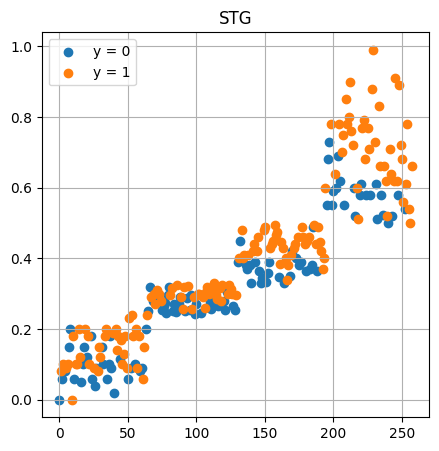

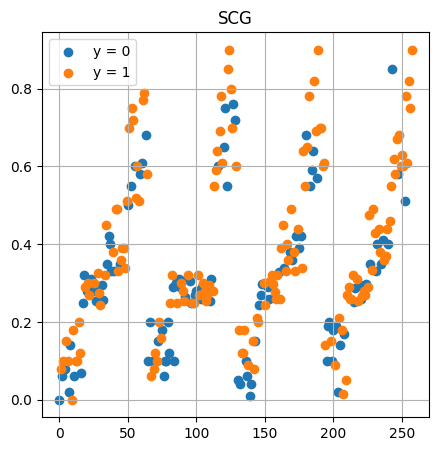

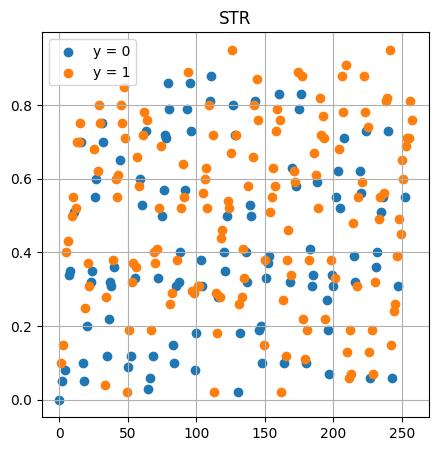

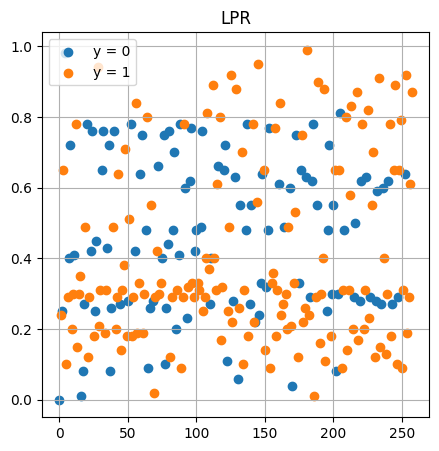

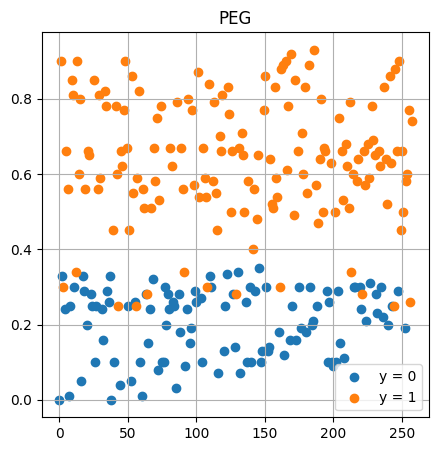

In [92]:
for feature in range(X.shape[1]):
    plt.figure(figsize=(5, 5))

    y0_objects = X.iloc[:, feature].where(y == 0).dropna()
    y1_objects = X.iloc[:, feature].where(y == 1).dropna()

    plt.scatter(y0_objects.index, y0_objects.values,label="y = 0")
    plt.scatter(y1_objects.index, y1_objects.values, label="y = 1")

    plt.title(X.columns[feature])
    plt.legend()
    plt.grid()
    plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [93]:
# Ответ: исходя из кривых значений критерия Джини деление выборки следует производить по признаку PEG, так как при нем достигается
# максимальное значение критерия Джини. Это подтверждается   диаграммой рассеивания для данного признака, так как он почти идеально
# отделяет объекты разных классов, в отличие от других признаков. Вид кривой для "хороших" признаков можно определить по наличию
# четко выраженного локального максимума (как на диаграмме для признака PEG). Вид кривой для признаков, по которым разделение
# практически невозможно это - практически прямая линия, значение критерия Джини практически не изменяется в зависимости от порога.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [94]:
!wget https://github.com/PiginIvan/Archives/raw/main/agaricus-lepiota.data

--2024-05-23 08:25:11--  https://github.com/PiginIvan/Archives/raw/main/agaricus-lepiota.data
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PiginIvan/Archives/main/agaricus-lepiota.data [following]
--2024-05-23 08:25:11--  https://raw.githubusercontent.com/PiginIvan/Archives/main/agaricus-lepiota.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373704 (365K) [text/plain]
Saving to: ‘agaricus-lepiota.data.1’

agaricus-lepiota.da 100%[===================>] 364.95K  --.-KB/s    in 0.008s  

2024-05-23 08:25:11 (43.0 MB/s) - ‘agaricus-lepiota.data.1’ saved [373704/373704]



In [95]:
df = pd.read_csv('agaricus-lepiota.data', header=None)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [96]:
from sklearn.preprocessing   import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

label_enc = LabelEncoder()
df = df.apply(lambda column: label_enc.fit_transform(column))

y = df[0]
X = df.drop(0, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.5, random_state=13)

dt = DecisionTree(['categorical'] * X_train.shape[1])
dt.fit(X_train, y_train)

print(f"Доля правильных ответов на тестовой выборке равна: {accuracy_score(dt.predict(X_test), y_test)}")

Доля правильных ответов на тестовой выборке равна: 0.9992614475627769


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [97]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [98]:
!wget https://github.com/PiginIvan/Archives/raw/main/diabetes.csv

--2024-05-23 08:25:11--  https://github.com/PiginIvan/Archives/raw/main/diabetes.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PiginIvan/Archives/main/diabetes.csv [following]
--2024-05-23 08:25:11--  https://raw.githubusercontent.com/PiginIvan/Archives/main/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23105 (23K) [text/plain]
Saving to: ‘diabetes.csv.1’

diabetes.csv.1      100%[===================>]  22.56K  --.-KB/s    in 0s      

2024-05-23 08:25:11 (92.5 MB/s) - ‘diabetes.csv.1’ saved [23105/23105]



In [99]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

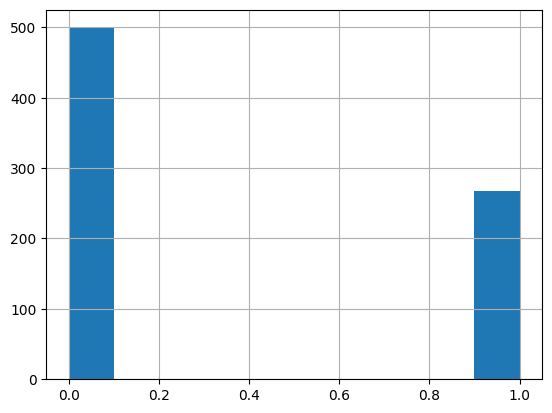

In [100]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [101]:
y = data["Outcome"]
X = data.drop(columns="Outcome")
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

print(f"Доля выборки от исходного датасета: обучающая-обучающая: {X_train.shape[0] / X.shape[0]}")
print(f"Доля выборки от исходного датасета: тестовая: {X_test.shape[0] / X.shape[0]}")
print(f"Доля выборки от исходного датасета: обучающая-валидационная: {X_val.shape[0] / X.shape[0]}")

Доля выборки от исходного датасета: обучающая-обучающая: 0.48828125
Доля выборки от исходного датасета: тестовая: 0.30078125
Доля выборки от исходного датасета: обучающая-валидационная: 0.2109375


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [111]:
from sklearn.metrics import f1_score

best_depth, best_leaves = 0, 0
depth_values, leaf_values = np.arange(1, 15), np.arange(1, 15)
max_f1 = 0
for cur_depth in depth_values:
    for cur_leaf in leaf_values:
        dtc = DecisionTreeClassifier(max_depth=cur_depth, min_samples_leaf=cur_leaf, random_state=228)
        dtc.fit(X_train, y_train)
        cur_f1 = f1_score(dtc.predict(X_val), y_val)
        if(max_f1 < cur_f1):
          best_depth = cur_depth
          best_leaves = cur_leaf
          max_f1 = cur_f1

print(f"Максимальное значение f1-меры: {max_f1}")
print(f"Оптимальная глубина: {best_depth}, оптимальное число листьев: {best_leaves}")

Максимальное значение f1-меры: 0.7017543859649122
Оптимальная глубина: 6, оптимальное число листьев: 7


In [112]:
dtc = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_leaves, random_state=228)

dtc.fit(X_train_full, y_train_full)
pred = dtc.predict(X_test)

print(f"Доля правильных ответов на тестовой выборки(accuracy): {accuracy_score(y_test, pred)}")
print(f"Точность на тестовой выборки(precision): {precision_score(y_test, pred)}")
print(f"Полнота на тестовой выборки(recall): {recall_score(y_test, pred)}")
print(f"AUC-ROC на тестовой выборки: {roc_auc_score(y_test, pred)}")

Доля правильных ответов на тестовой выборки(accuracy): 0.683982683982684
Точность на тестовой выборки(precision): 0.5339805825242718
Полнота на тестовой выборки(recall): 0.6875
AUC-ROC на тестовой выборки: 0.6848096026490066


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [104]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(n_estimators=50, random_state=228)

bc.fit(X_train_full, y_train_full)
pred = bc.predict(X_test)

print(f"Доля правильных ответов на тестовой выборки(accuracy): {accuracy_score(y_test, pred)}")
print(f"Точность на тестовой выборки(precision): {precision_score(y_test, pred)}")
print(f"Полнота на тестовой выборки(recall): {recall_score(y_test, pred)}")
print(f"AUC-ROC на тестовой выборки: {roc_auc_score(y_test, pred)}")

Доля правильных ответов на тестовой выборки(accuracy): 0.7489177489177489
Точность на тестовой выборки(precision): 0.625
Полнота на тестовой выборки(recall): 0.6875
AUC-ROC на тестовой выборки: 0.734478476821192


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [105]:
from sklearn.model_selection import cross_validate

best_depth, best_split = 0, 0
depth_values, split_values = np.arange(1, 15), np.arange(2, 15)
best_score = 0

for cur_depth in depth_values:
    for cur_split in split_values:
        rfc = RandomForestClassifier(n_estimators=50, max_depth=cur_depth, min_samples_split=cur_split, random_state=228)
        cur_scores = cross_validate(rfc, X_train_full, y_train_full, scoring=["f1"], cv=3)
        cur_score = cur_scores["test_f1"].mean()
        if(best_score < cur_score):
          best_depth = cur_depth
          best_split = cur_split
          best_score = cur_score

print(f"Наилучшее среднее качество: {best_score}")
print(f"Оптимальная глубина: {best_depth}, оптимальное число разбиений: {best_split}")


Наилучшее среднее качество: 0.6696690740175635
Оптимальная глубина: 11, оптимальное число разбиений: 2


In [106]:
rfc = RandomForestClassifier(n_estimators=50, max_depth=best_depth, min_samples_split=best_split, random_state=228)

rfc.fit(X_train_full, y_train_full)
pred = rfc.predict(X_test)

print(f"Доля правильных ответов на тестовой выборки(accuracy): {accuracy_score(y_test, pred)}")
print(f"Точность на тестовой выборки(precision): {precision_score(y_test, pred)}")
print(f"Полнота на тестовой выборки(recall): {recall_score(y_test, pred)}")
print(f"AUC-ROC на тестовой выборки: {roc_auc_score(y_test, pred)}")

Доля правильных ответов на тестовой выборки(accuracy): 0.7619047619047619
Точность на тестовой выборки(precision): 0.6623376623376623
Полнота на тестовой выборки(recall): 0.6375
AUC-ROC на тестовой выборки: 0.7326572847682119


In [107]:
# Ответ: лучше всего себя показала такая модель, как RandomForestClassifier с max_depth=11 и min_samples_split=2.
# Она имеет наилучшие метрики качества, по которым мы сравнивали модели(accuracy, precision, recall, AUC-ROC).

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [108]:
count_of_trees = np.arange(1, 200)
auc_roc_values = []

for cur_count in range(1, 200):
  rf = RandomForestClassifier(n_estimators=cur_count, random_state=228)
  rf.fit(X_train_full, y_train_full)

  auc_roc_values.append(roc_auc_score(rf.predict(X_test), y_test))

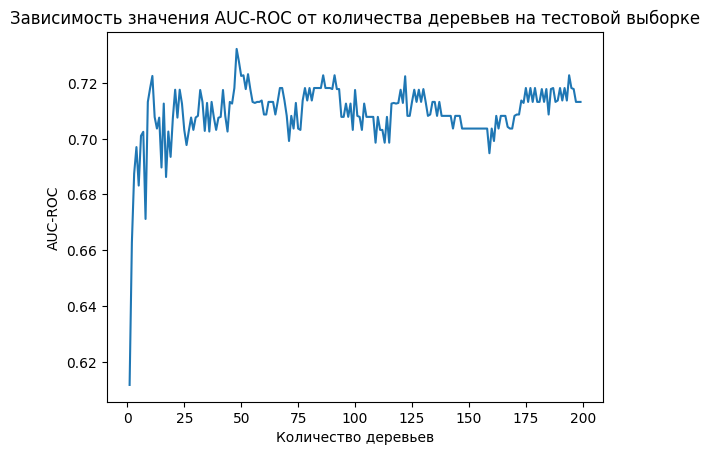

In [109]:
plt.plot(count_of_trees, auc_roc_values)
plt.xlabel("Количество деревьев")
plt.ylabel("AUC-ROC")
plt.title("Зависимость значения AUC-ROC от количества деревьев на тестовой выборке")
plt.show()

# По графику видно, что при слишком малом количестве деревьев AUC-ROC принимает очень малое значение, соответственно
# количество деревьев от 1 до 10 лучше не использовать. Также можно заметить, что для количества деревьев
# от 30 до 200 AUC-ROC колеблеться в пределах от 0.7 до 0.725, то есть значения примерно одинаковы и еще больше
# увеличивать число деревьев не нужно.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

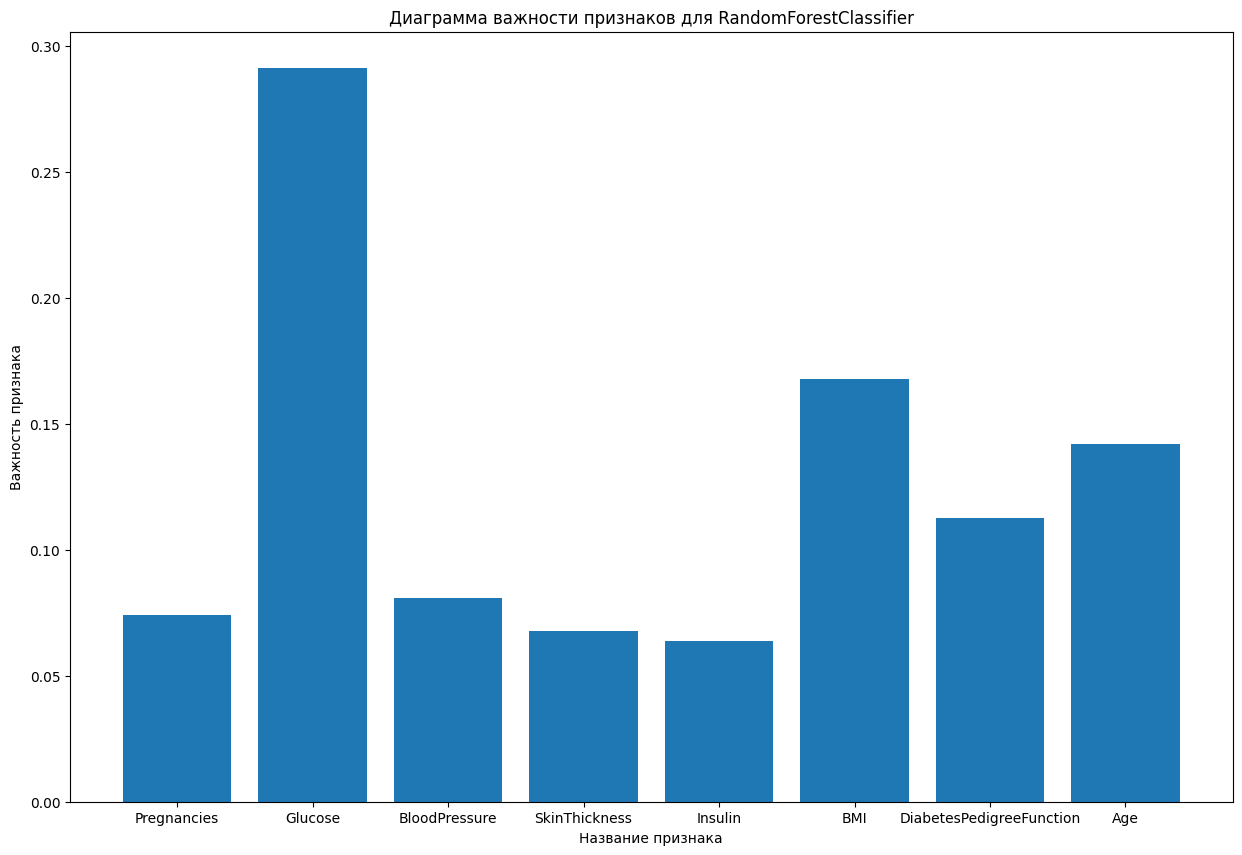

In [110]:
importances = rfc.feature_importances_

fig = plt.figure(figsize=(15, 10))
plt.bar(X.columns, importances)
plt.xlabel("Название признака")
plt.ylabel("Важность признака")
plt.title("Диаграмма важности признаков для RandomForestClassifier")
plt.show()

# Самым ценным признаком оказался Glucose, так как он имеет самый высокий стоблец(наиболее важен).